/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/2343887135.py:19: RuntimeWarning: invalid value encountered in power
  return np.where(valid, amp * a * np.power(b + (x - mean) / sigma, -n), np.nan)


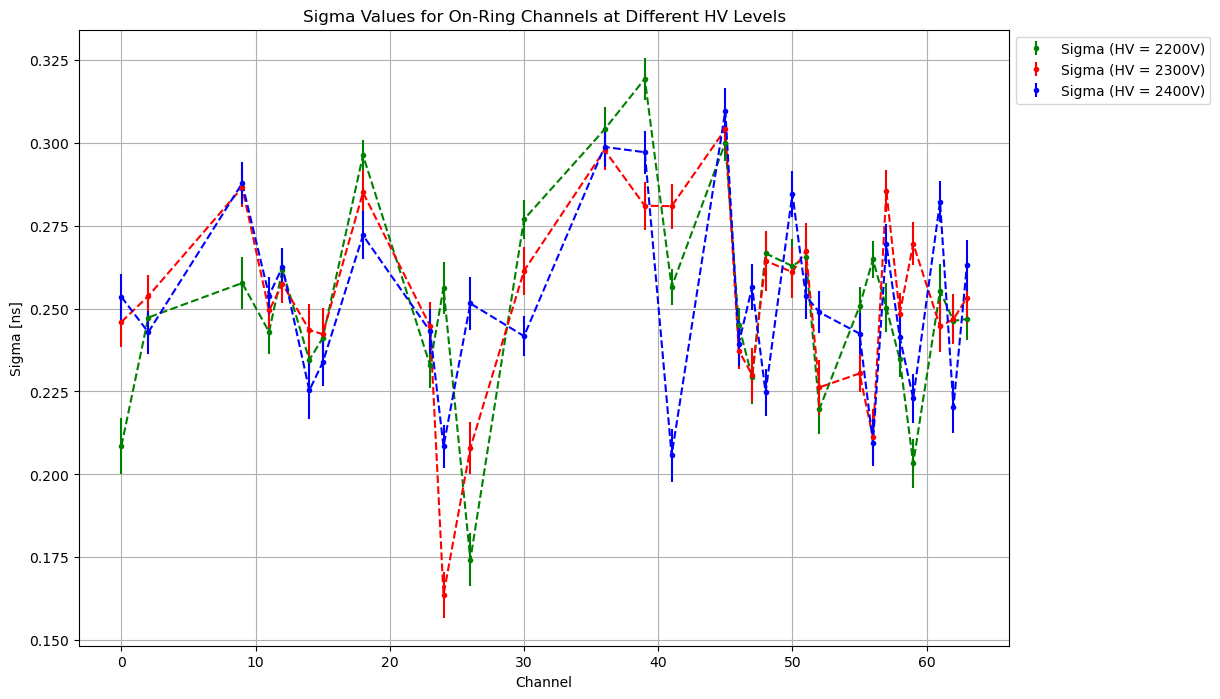

In [51]:
import uproot
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def crystalball(x, amp, mean, sigma, alpha, n):
    """Crystal Ball function definition with right tail"""
    sqrt_pi_over_2 = np.sqrt(np.pi / 2)
    sqrt_2 = np.sqrt(2)
    
    a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
    b = n / np.abs(alpha) - np.abs(alpha)
    
    def left_tail(x):
        return amp * np.exp(-np.power(x - mean, 2) / (2 * sigma ** 2))
    
    def right_tail(x):
        valid = (b + (x - mean) / sigma) > 0
        return np.where(valid, amp * a * np.power(b + (x - mean) / sigma, -n), np.nan)
    
    result = np.where((x - mean) / sigma > alpha, right_tail(x), left_tail(x))
    return result

def import_data(file_path, hist_name):
    root_file = uproot.open(file_path)
    hist = root_file[hist_name]
    w, x_edges, y_edges = hist.to_numpy()
    return w, x_edges, y_edges 

on_ring_channels = [56, 58, 47, 46, 62, 51, 55, 48, 45, 61, 57, 52, 41, 50, 39, 30, 59, 36, 2, 24, 0, 26, 63, 23, 12, 18, 14, 15, 9, 11]

file_paths = {
    "412": "run_0412_afterTWC.root",  # HV 2200V
    "419": "run_0419_afterTWC.root",  # HV 2300V
    "427": "run_0427_afterTWC.root"   # HV 2400V
}

sigmas = {
    "412": {},
    "419": {},
    "427": {}
}

errors = {
    "412": {},
    "419": {},
    "427": {}
}

for file_key, file_path in file_paths.items():
    for channel in on_ring_channels:
        try:
            hist_name_template = 'corrected_hist_ch{0};1'
            hist_name = hist_name_template.format(channel)
            w, ToT_edges, ToA_edges = import_data(file_path, hist_name)

            uniform_bin_width = 0.1
            uniform_bin_edges = np.arange(-10, 20 + uniform_bin_width, uniform_bin_width)
            cumulative_event_counts = np.zeros(len(uniform_bin_edges) - 1)

            bin_edges = ToA_edges
            bin_widths = np.diff(bin_edges)
            event_counts_per_bin = np.sum(w, axis=0)

            for j in range(len(bin_edges) - 1):
                bin_min = bin_edges[j]
                bin_max = bin_edges[j + 1]
                bin_event_count = event_counts_per_bin[j]
                uniform_bin_mask = (uniform_bin_edges[:-1] < bin_max) & (uniform_bin_edges[1:] > bin_min)
                overlap_bins = np.where(uniform_bin_mask)[0]

                for bin_idx in overlap_bins:
                    overlap_min = max(bin_min, uniform_bin_edges[bin_idx])
                    overlap_max = min(bin_max, uniform_bin_edges[bin_idx + 1])
                    overlap_fraction = (overlap_max - overlap_min) / (bin_max - bin_min)
                    cumulative_event_counts[bin_idx] += bin_event_count * overlap_fraction

            uniform_bin_centers = (uniform_bin_edges[:-1] + uniform_bin_edges[1:]) / 2
            fit_range_mask = (uniform_bin_centers >= -4) & (uniform_bin_centers <= 10)
            fit_bin_centers = uniform_bin_centers[fit_range_mask]
            fit_event_counts = cumulative_event_counts[fit_range_mask]

            initial_guess = [fit_event_counts.max(), fit_bin_centers[np.argmax(fit_event_counts)], 1, 1.5, 2]

            popt, pcov = curve_fit(crystalball, fit_bin_centers, fit_event_counts, p0=initial_guess, bounds=([0, -np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, 5, 10]))
            sigma = popt[2]
            sigma_error = np.sqrt(np.diag(pcov))[2]

            sigmas[file_key][channel] = sigma
            errors[file_key][channel] = sigma_error

        except Exception as e:
            print(f"Error processing channel {channel} in file {file_key}: {e}")
            sigmas[file_key][channel] = np.nan
            errors[file_key][channel] = np.nan

plt.figure(figsize=(12, 8))

channels = sorted(on_ring_channels)
sigma_values_412 = [sigmas["412"][channel] for channel in channels]
sigma_errors_412 = [errors["412"][channel] for channel in channels]

sigma_values_419 = [sigmas["419"][channel] for channel in channels]
sigma_errors_419 = [errors["419"][channel] for channel in channels]

sigma_values_427 = [sigmas["427"][channel] for channel in channels]
sigma_errors_427 = [errors["427"][channel] for channel in channels]

plt.errorbar(channels, sigma_values_412, yerr=sigma_errors_412, fmt='o', color='green', label='Sigma (HV = 2200V)', markersize=3)
plt.plot(channels, sigma_values_412, 'g--')

plt.errorbar(channels, sigma_values_419, yerr=sigma_errors_419, fmt='o', color='red', label='Sigma (HV = 2300V)', markersize=3)
plt.plot(channels, sigma_values_419, 'r--')

plt.errorbar(channels, sigma_values_427, yerr=sigma_errors_427, fmt='o', color='blue', label='Sigma (HV = 2400V)', markersize=3)
plt.plot(channels, sigma_values_427, 'b--')

plt.xlabel('Channel')
plt.ylabel('Sigma [ns]')
plt.title('Sigma Values for On-Ring Channels at Different HV Levels')
plt.grid(True)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('../TWC_Result/Corrected_mean_diffHV_onring.png', bbox_inches='tight')

plt.show()


/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/3076650832.py:19: RuntimeWarning: invalid value encountered in power
  return np.where(valid, amp * a * np.power(b + (x - mean) / sigma, -n), np.nan)


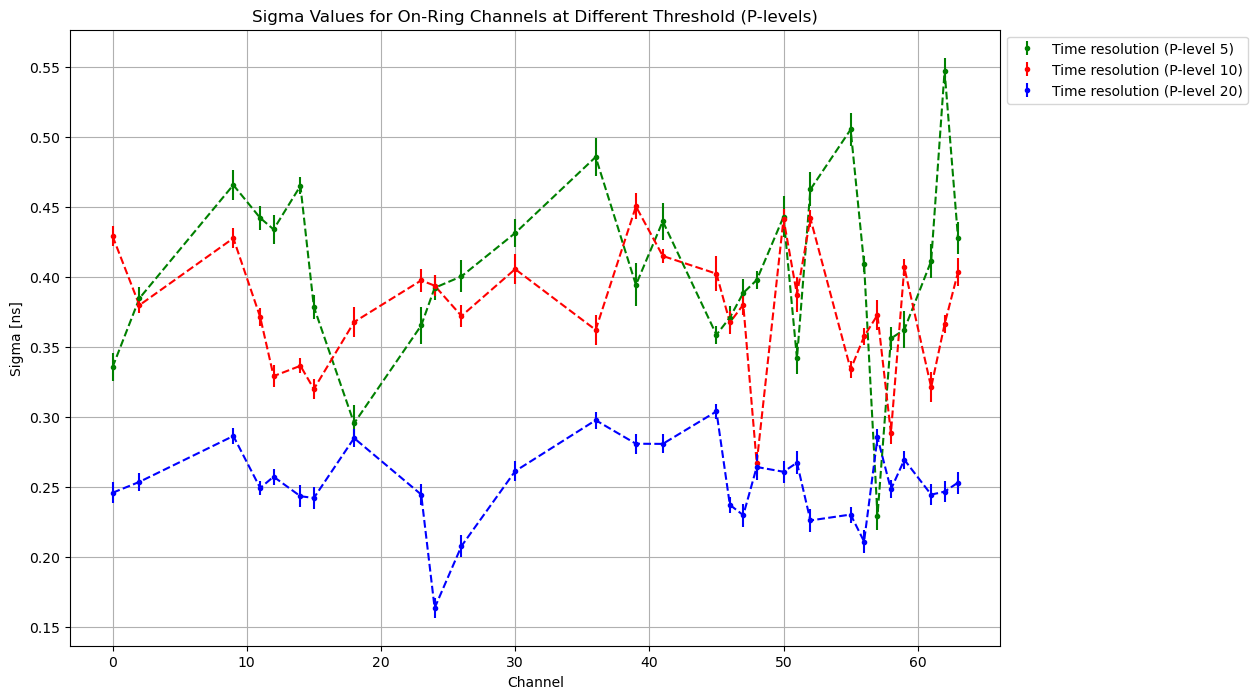

In [57]:
import uproot
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def crystalball(x, amp, mean, sigma, alpha, n):
    """Crystal Ball function definition with right tail"""
    sqrt_pi_over_2 = np.sqrt(np.pi / 2)
    sqrt_2 = np.sqrt(2)
    
    a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
    b = n / np.abs(alpha) - np.abs(alpha)
    
    def left_tail(x):
        return amp * np.exp(-np.power(x - mean, 2) / (2 * sigma ** 2))
    
    def right_tail(x):
        valid = (b + (x - mean) / sigma) > 0
        return np.where(valid, amp * a * np.power(b + (x - mean) / sigma, -n), np.nan)
    
    result = np.where((x - mean) / sigma > alpha, right_tail(x), left_tail(x))
    return result

def import_data(file_path, hist_name):
    root_file = uproot.open(file_path)
    hist = root_file[hist_name]
    w, x_edges, y_edges = hist.to_numpy()
    return w, x_edges, y_edges 

on_ring_channels = [56, 58, 47, 46, 62, 51, 55, 48, 45, 61, 57, 52, 41, 50, 39, 30, 59, 36, 2, 24, 0, 26, 63, 23, 12, 18, 14, 15, 9, 11]

file_paths = {
    "412": "run_0341_afterTWC.root",  # Time resolution (P-level 5)
    "419": "run_0371_afterTWC.root",  # Time resolution (P-level 10)
    "427": "run_0419_afterTWC.root"   # Time resolution (P-level 20)
}

sigmas = {
    "412": {},
    "419": {},
    "427": {}
}

errors = {
    "412": {},
    "419": {},
    "427": {}
}

for file_key, file_path in file_paths.items():
    for channel in on_ring_channels:
        try:
            hist_name_template = 'corrected_hist_ch{0};1'
            hist_name = hist_name_template.format(channel)
            w, ToT_edges, ToA_edges = import_data(file_path, hist_name)

            uniform_bin_width = 0.1
            uniform_bin_edges = np.arange(-10, 20 + uniform_bin_width, uniform_bin_width)
            cumulative_event_counts = np.zeros(len(uniform_bin_edges) - 1)

            bin_edges = ToA_edges
            event_counts_per_bin = np.sum(w, axis=0)

            for j in range(len(bin_edges) - 1):
                bin_min = bin_edges[j]
                bin_max = bin_edges[j + 1]
                bin_event_count = event_counts_per_bin[j]
                uniform_bin_mask = (uniform_bin_edges[:-1] < bin_max) & (uniform_bin_edges[1:] > bin_min)
                overlap_bins = np.where(uniform_bin_mask)[0]

                for bin_idx in overlap_bins:
                    overlap_min = max(bin_min, uniform_bin_edges[bin_idx])
                    overlap_max = min(bin_max, uniform_bin_edges[bin_idx + 1])
                    overlap_fraction = (overlap_max - overlap_min) / (bin_max - bin_min)
                    cumulative_event_counts[bin_idx] += bin_event_count * overlap_fraction

            uniform_bin_centers = (uniform_bin_edges[:-1] + uniform_bin_edges[1:]) / 2
            fit_range_mask = (uniform_bin_centers >= -4) & (uniform_bin_centers <= 10)
            fit_bin_centers = uniform_bin_centers[fit_range_mask]
            fit_event_counts = cumulative_event_counts[fit_range_mask]

            initial_guess = [fit_event_counts.max(), fit_bin_centers[np.argmax(fit_event_counts)], 1, 1.5, 2]

            popt, pcov = curve_fit(crystalball, fit_bin_centers, fit_event_counts, p0=initial_guess, bounds=([0, -np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, 5, 10]))
            sigma = popt[2]
            sigma_error = np.sqrt(np.diag(pcov))[2]

            sigmas[file_key][channel] = sigma
            errors[file_key][channel] = sigma_error

        except Exception as e:
            print(f"Error processing channel {channel} in file {file_key}: {e}")
            sigmas[file_key][channel] = np.nan
            errors[file_key][channel] = np.nan

plt.figure(figsize=(12, 8))

channels = sorted(on_ring_channels)

sigma_values_412 = [sigmas["412"][channel] for channel in channels]
sigma_errors_412 = [errors["412"][channel] for channel in channels]

sigma_values_419 = [sigmas["419"][channel] for channel in channels]
sigma_errors_419 = [errors["419"][channel] for channel in channels]

sigma_values_427 = [sigmas["427"][channel] for channel in channels]
sigma_errors_427 = [errors["427"][channel] for channel in channels]

plt.errorbar(channels, sigma_values_412, yerr=sigma_errors_412, fmt='o', color='green', label='Time resolution (P-level 5)', markersize=3)
plt.plot(channels, sigma_values_412, 'g--')

plt.errorbar(channels, sigma_values_419, yerr=sigma_errors_419, fmt='o', color='red', label='Time resolution (P-level 10)', markersize=3)
plt.plot(channels, sigma_values_419, 'r--')

plt.errorbar(channels, sigma_values_427, yerr=sigma_errors_427, fmt='o', color='blue', label='Time resolution (P-level 20)', markersize=3)
plt.plot(channels, sigma_values_427, 'b--')

plt.xlabel('Channel')
plt.ylabel('Sigma [ns]')
plt.title('Sigma Values for On-Ring Channels at Different Threshold (P-levels)')
plt.grid(True)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('../TWC_Result/Corrected_mean_diffthreshold_onring.png', bbox_inches='tight')

plt.show()


In [58]:
import uproot
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import csv
#Save as CSV

def crystalball(x, amp, mean, sigma, alpha, n):
    """Crystal Ball function definition with right tail"""
    sqrt_pi_over_2 = np.sqrt(np.pi / 2)
    sqrt_2 = np.sqrt(2)
    
    a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
    b = n / np.abs(alpha) - np.abs(alpha)
    
    def left_tail(x):
        return amp * np.exp(-np.power(x - mean, 2) / (2 * sigma ** 2))
    
    def right_tail(x):
        valid = (b + (x - mean) / sigma) > 0
        return np.where(valid, amp * a * np.power(b + (x - mean) / sigma, -n), np.nan)
    
    result = np.where((x - mean) / sigma > alpha, right_tail(x), left_tail(x))
    return result

def import_data(file_path, hist_name):
    root_file = uproot.open(file_path)
    hist = root_file[hist_name]
    w, x_edges, y_edges = hist.to_numpy()
    return w, x_edges, y_edges 

on_ring_channels = [56, 58, 47, 46, 62, 51, 55, 48, 45, 61, 57, 52, 41, 50, 39, 30, 59, 36, 2, 24, 0, 26, 63, 23, 12, 18, 14, 15, 9, 11]
all_channels = [i for i in range(64) if i not in [1, 7, 21]]  

file_path = "run_0419_afterTWC.root"  # Assuming we're only using 419 for this example

sigmas = {}
errors = {}

for channel in all_channels:
    try:
        hist_name_template = 'corrected_hist_ch{0};1'
        hist_name = hist_name_template.format(channel)
        w, ToT_edges, ToA_edges = import_data(file_path, hist_name)

        uniform_bin_width = 0.1
        uniform_bin_edges = np.arange(-10, 20 + uniform_bin_width, uniform_bin_width)
        cumulative_event_counts = np.zeros(len(uniform_bin_edges) - 1)

        bin_edges = ToA_edges
        bin_widths = np.diff(bin_edges)
        event_counts_per_bin = np.sum(w, axis=0)

        for j in range(len(bin_edges) - 1):
            bin_min = bin_edges[j]
            bin_max = bin_edges[j + 1]
            bin_event_count = event_counts_per_bin[j]
            uniform_bin_mask = (uniform_bin_edges[:-1] < bin_max) & (uniform_bin_edges[1:] > bin_min)
            overlap_bins = np.where(uniform_bin_mask)[0]

            for bin_idx in overlap_bins:
                overlap_min = max(bin_min, uniform_bin_edges[bin_idx])
                overlap_max = min(bin_max, uniform_bin_edges[bin_idx + 1])
                overlap_fraction = (overlap_max - overlap_min) / (bin_max - bin_min)
                cumulative_event_counts[bin_idx] += bin_event_count * overlap_fraction

        uniform_bin_centers = (uniform_bin_edges[:-1] + uniform_bin_edges[1:]) / 2
        fit_range_mask = (uniform_bin_centers >= -5) & (uniform_bin_centers <= 10)
        fit_bin_centers = uniform_bin_centers[fit_range_mask]
        fit_event_counts = cumulative_event_counts[fit_range_mask]

        initial_guess = [fit_event_counts.max(), fit_bin_centers[np.argmax(fit_event_counts)], 1, 1.5, 2]

        popt, pcov = curve_fit(crystalball, fit_bin_centers, fit_event_counts, p0=initial_guess, bounds=([0, -np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, 5, 10]))
        sigma = popt[2]
        sigma_error = np.sqrt(np.diag(pcov))[2]

        sigmas[channel] = sigma
        errors[channel] = sigma_error

    except Exception as e:
        print(f"Error processing channel {channel}: {e}")
        sigmas[channel] = np.nan
        errors[channel] = np.nan

# Save to CSV
output_file = "corrected_sigma_419.csv"
with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['Channel', 'Sigma', 'Sigma_Error']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for channel in all_channels:
        writer.writerow({'Channel': channel, 'Sigma': sigmas[channel], 'Sigma_Error': errors[channel]})

print(f"Corrected sigma data saved to {output_file}")


/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/1846709917.py:20: RuntimeWarning: invalid value encountered in power
  return np.where(valid, amp * a * np.power(b + (x - mean) / sigma, -n), np.nan)


Corrected sigma data saved to corrected_sigma_419.csv


In [38]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

def crystalball(x, amp, mean, sigma, alpha, n):
    a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
    b = n / np.abs(alpha) - np.abs(alpha)
    
    def left_tail(x):
        return amp * np.exp(-np.power(x - mean, 2) / (2 * sigma ** 2))
    
    def right_tail(x):
        return amp * a * np.power(b + (x - mean) / sigma, -n)
    
    result = np.where((x - mean) / sigma > alpha, right_tail(x), left_tail(x))
    return result

def import_data(file_path, hist_name):
    root_file = uproot.open(file_path)
    hist = root_file[hist_name]
    w, x_edges, y_edges = hist.to_numpy()
    return w, x_edges, y_edges 

file_path = 'run_0419_afterTWC.root'
excluded_channels = [1, 7, 21]
all_channels = [ch for ch in range(64) if ch not in excluded_channels]
on_ring_channels = [56, 58, 47, 46, 62, 51, 55, 48, 45, 61, 57, 52, 41, 50, 39, 30, 59, 36, 2, 24, 0, 26, 63, 23, 12, 18, 14, 15, 9, 11]

max_tot_sigmas = {}
errors_max_tot = {}


for channel in all_channels:
    try:
        hist_name_template = 'original_hist_ch{0};1'
        hist_name = hist_name_template.format(channel)
        w, ToT_edges, ToA_edges = import_data(file_path, hist_name)

        max_tot_bin_index = np.argmax(np.sum(w, axis=1))
        max_tot_bin_counts = w[max_tot_bin_index, :]

        non_zero_mask = max_tot_bin_counts > 0
        non_zero_ToA_edges = ToA_edges[:-1][non_zero_mask]
        non_zero_event_counts = max_tot_bin_counts[non_zero_mask]

        initial_guess_max_tot = [non_zero_event_counts.max(), non_zero_ToA_edges[np.argmax(non_zero_event_counts)], 1, 1.5, 2]

        popt_max_tot, pcov_max_tot = curve_fit(crystalball, non_zero_ToA_edges, non_zero_event_counts, p0=initial_guess_max_tot)
        sigma_max_tot = popt_max_tot[2]
        error_max_tot = np.sqrt(np.diag(pcov_max_tot))[2]

        max_tot_sigmas[channel] = sigma_max_tot
        errors_max_tot[channel] = error_max_tot

    except Exception as e:
        max_tot_sigmas[channel] = np.nan
        errors_max_tot[channel] = np.nan
        print(f"Max ToT bin fit failed for channel {channel}: {e}")

output_file = "max_tot_sigma_419.csv"
with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['Channel', 'Sigma', 'Sigma_Error']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for channel in all_channels:
        writer.writerow({'Channel': channel, 'Sigma': max_tot_sigmas[channel], 'Sigma_Error': errors_max_tot[channel]})

print(f"Max ToT sigma data saved to {output_file}")


/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/2436189710.py:16: RuntimeWarning: invalid value encountered in power
  return amp * a * np.power(b + (x - mean) / sigma, -n)
/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/2436189710.py:9: RuntimeWarning: invalid value encountered in power
  a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/2436189710.py:9: RuntimeWarning: overflow encountered in power
  a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/2436189710.py:16: RuntimeWarning: invalid value encountered in multiply
  return amp * a * np.power(b + (x - mean) / sigma, -n)
/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/2436189710.py:16: RuntimeWarning: overflow encountered in scalar multiply
  return amp * a * np.power(b + (x - mean) / sigma, -n)


Max ToT sigma data saved to max_tot_sigma_419.csv


/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/850463127.py:16: RuntimeWarning: invalid value encountered in power
  return amp * a * np.power(b + (x - mean) / sigma, -n)
/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/850463127.py:9: RuntimeWarning: overflow encountered in power
  a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/850463127.py:16: RuntimeWarning: invalid value encountered in multiply
  return amp * a * np.power(b + (x - mean) / sigma, -n)
/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/850463127.py:16: RuntimeWarning: overflow encountered in scalar multiply
  return amp * a * np.power(b + (x - mean) / sigma, -n)
/var/folders/2k/_7q8s6vx7pxdg82l04tnjz_00000gn/T/ipykernel_85697/850463127.py:9: RuntimeWarning: invalid value encountered in power
  a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)


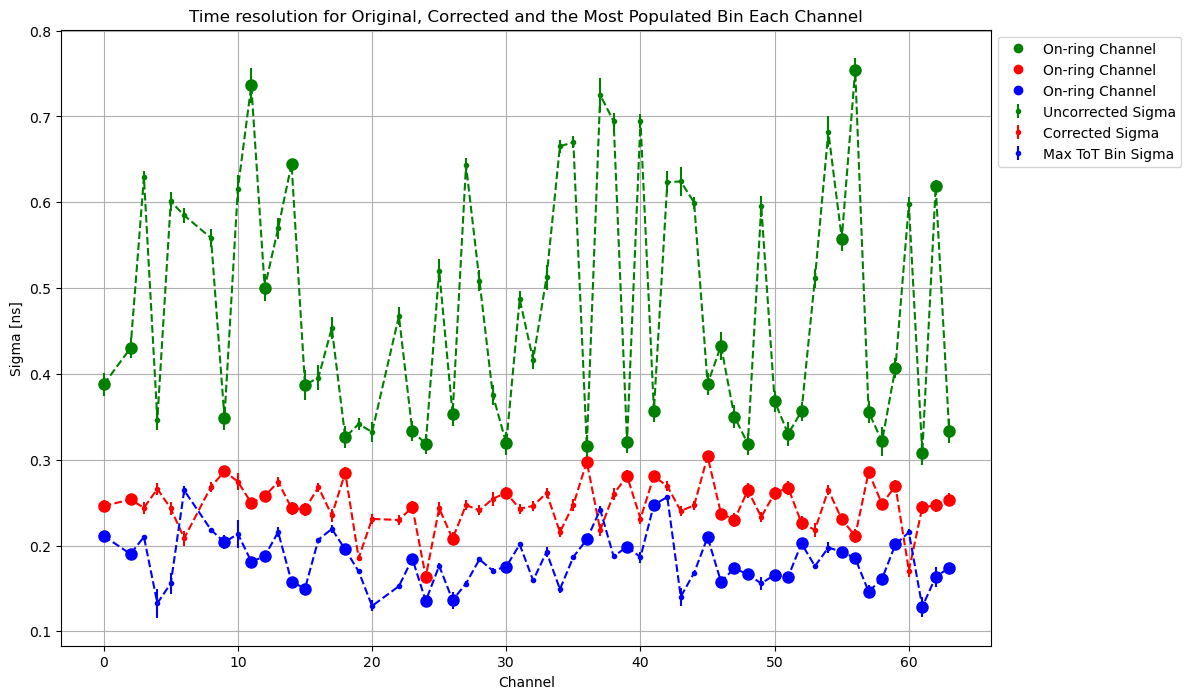

In [59]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

#Readout out 3 curves
def crystalball(x, amp, mean, sigma, alpha, n):
    a = np.power(n / np.abs(alpha), n) * np.exp(-np.power(np.abs(alpha), 2) / 2)
    b = n / np.abs(alpha) - np.abs(alpha)
    
    def left_tail(x):
        return amp * np.exp(-np.power(x - mean, 2) / (2 * sigma ** 2))
    
    def right_tail(x):
        return amp * a * np.power(b + (x - mean) / sigma, -n)
    
    result = np.where((x - mean) / sigma > alpha, right_tail(x), left_tail(x))
    return result

# Import data function for histograms
def import_data(file_path, hist_name):
    root_file = uproot.open(file_path)
    hist = root_file[hist_name]
    w, x_edges, y_edges = hist.to_numpy()
    return w, x_edges, y_edges 

file_path = 'run_0419_afterTWC.root'
excluded_channels = [1, 7, 21]
all_channels = [ch for ch in range(64) if ch not in excluded_channels]
on_ring_channels = [56, 58, 47, 46, 62, 51, 55, 48, 45, 61, 57, 52, 41, 50, 39, 30, 59, 36, 2, 24, 0, 26, 63, 23, 12, 18, 14, 15, 9, 11]

# Load corrected sigma data from CSV
corrected_sigma_data = pd.read_csv("corrected_sigma_419.csv")
max_tot_sigma_data = pd.read_csv("max_tot_sigma_419.csv")

uncorrected_sigmas = {}
errors_uncorrected = {}

bin_width = 0.1
y_min = -130
y_max = -100
uniform_bin_edges = np.arange(y_min, y_max + bin_width, bin_width)

for channel in all_channels:
    hist_name_template = 'original_hist_ch{0};1'
    hist_name = hist_name_template.format(channel)

    try:
        w, ToT_edges, ToA_edges = import_data(file_path, hist_name)

        y_indices = np.where((ToA_edges >= y_min) & (ToA_edges <= y_max))[0]
        if ToA_edges[y_indices[-1]] > y_max:
            y_indices = y_indices[:-1]

        w_sliced = w[:, y_indices[:-1]]
        ToA_edges_sliced = ToA_edges[y_indices]

        # Accumulate data in uniform bins
        uniform_event_counts_per_bin = np.zeros(len(uniform_bin_edges) - 1)
        for i in range(len(ToA_edges_sliced) - 1):
            bin_min = ToA_edges_sliced[i]
            bin_max = ToA_edges_sliced[i + 1]
            bin_event_count = np.sum(w_sliced[:, i])

            uniform_bin_mask = (uniform_bin_edges[:-1] < bin_max) & (uniform_bin_edges[1:] > bin_min)
            overlap_bins = np.where(uniform_bin_mask)[0]

            for bin_idx in overlap_bins:
                overlap_min = max(bin_min, uniform_bin_edges[bin_idx])
                overlap_max = min(bin_max, uniform_bin_edges[bin_idx + 1])
                overlap_fraction = (overlap_max - overlap_min) / (bin_max - bin_min)
                
                uniform_event_counts_per_bin[bin_idx] += bin_event_count * overlap_fraction

        # Fitting Crystal Ball function to uncorrected data
        uniform_bin_centers = (uniform_bin_edges[:-1] + uniform_bin_edges[1:]) / 2
        fit_range_mask = (uniform_bin_centers >= -125) & (uniform_bin_centers <= -115)
        fit_bin_centers = uniform_bin_centers[fit_range_mask]
        fit_event_counts = uniform_event_counts_per_bin[fit_range_mask]

        initial_guess = [fit_event_counts.max(), fit_bin_centers[np.argmax(fit_event_counts)], 1, 1.5, 2]

        popt_uncorrected, pcov_uncorrected = curve_fit(crystalball, fit_bin_centers, fit_event_counts, p0=initial_guess)
        sigma_uncorrected = popt_uncorrected[2]
        error_uncorrected = np.sqrt(np.diag(pcov_uncorrected))[2]

        uncorrected_sigmas[channel] = sigma_uncorrected
        errors_uncorrected[channel] = error_uncorrected

    except KeyError:
        uncorrected_sigmas[channel] = np.nan
        errors_uncorrected[channel] = np.nan
        print(f"Uncorrected histogram for channel {channel} not found, skipping.")
    except RuntimeError as e:
        print(f"Fit failed for channel {channel}: {e}")
        uncorrected_sigmas[channel] = np.nan
        errors_uncorrected[channel] = np.nan

plt.figure(figsize=(12, 8))

sorted_channels = sorted(all_channels)

uncorrected_sigma_values = [uncorrected_sigmas[ch] for ch in sorted_channels]
errors_uncorrected_values = [errors_uncorrected[ch] for ch in sorted_channels]

corrected_sigma_values = [corrected_sigma_data.loc[corrected_sigma_data['Channel'] == ch, 'Sigma'].values[0] for ch in sorted_channels]
corrected_sigma_errors = [corrected_sigma_data.loc[corrected_sigma_data['Channel'] == ch, 'Sigma_Error'].values[0] for ch in sorted_channels]

max_tot_sigma_values = [max_tot_sigma_data.loc[max_tot_sigma_data['Channel'] == ch, 'Sigma'].values[0] for ch in sorted_channels]
max_tot_sigma_errors = [max_tot_sigma_data.loc[max_tot_sigma_data['Channel'] == ch, 'Sigma_Error'].values[0] for ch in sorted_channels]

plt.errorbar(sorted_channels, uncorrected_sigma_values, yerr=errors_uncorrected_values, fmt='o', color='green', label='Uncorrected Sigma', markersize=3)
plt.plot(sorted_channels, uncorrected_sigma_values, 'g--')

plt.errorbar(sorted_channels, corrected_sigma_values, yerr=corrected_sigma_errors, fmt='o', color='red', label='Corrected Sigma', markersize=3)
plt.plot(sorted_channels, corrected_sigma_values, 'r--')

plt.errorbar(sorted_channels, max_tot_sigma_values, yerr=max_tot_sigma_errors, fmt='o', color='blue', label='Max ToT Bin Sigma', markersize=3)
plt.plot(sorted_channels, max_tot_sigma_values, 'b--')

for channel in on_ring_channels:
    if channel in sorted_channels:
        idx = sorted_channels.index(channel)
        plt.plot(sorted_channels[idx], uncorrected_sigma_values[idx], 'go', markersize=8, label='_nolegend_')
        plt.plot(sorted_channels[idx], corrected_sigma_values[idx], 'ro', markersize=8, label='_nolegend_')
        plt.plot(sorted_channels[idx], max_tot_sigma_values[idx], 'bo', markersize=8, label='_nolegend_')

plt.plot([], [], 'go', label='On-ring Channel')
plt.plot([], [], 'ro', label='On-ring Channel')
plt.plot([], [], 'bo', label='On-ring Channel')

plt.xlabel('Channel')
plt.ylabel('Sigma [ns]')
plt.title('Time resolution for Original, Corrected and the Most Populated Bin Each Channel')
plt.grid(True)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('../TWC_Result/sigma_combined_with_max_bin_and_initial.png', bbox_inches='tight')

plt.show()
